In [1]:
!pip install timm

# Import libraries

In [2]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import LabelEncoder, label_binarize
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import torch.optim as optim
import torchvision.models as models
import time
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc, f1_score, roc_auc_score
import seaborn as sns
from itertools import cycle
from collections import Counter
import timm

/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'repr' attribute with value False was provided to the `Field()` function, which has no effect in the context it was used. 'repr' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` statement was used, or if the `Field()` function was attached to a single member of a union type.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/pydantic/_internal/_generate_schema.py:2249: UnsupportedFieldAttributeWarning: The 'frozen' attribute with value True was provided to the `Field()` function, which has no effect in the context it was used. 'frozen' is field-specific metadata, and can only be attached to a model field using `Annotated` metadata or by assignment. This may have happened because an `Annotated` type alias using the `type` 

# Set Seeds for Reproducibility

In [3]:
import random

# Set seeds for reproducibility
SEED = 42

# Python random
random.seed(SEED)

# Numpy
np.random.seed(SEED)

# PyTorch
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)  # if using multi-GPU

# PyTorch backend
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

print(f"Seeds set to {SEED} for reproducibility")

Seeds set to 42 for reproducibility


# Data Transformation

In [4]:
# Data transformations - Minimal transformations without data augmentation
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

val_test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.ConvertImageDtype(torch.float),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # RGB normalization
])

# Dataset

In [5]:
BATCH_SIZE = 16
NUM_WORKERS = 4

class BladderTissueDataset(Dataset):
    def __init__(self, dataframe, transform=None, label_encoder=None, fit_label_encoder=False, 
                 imaging_type_encoder=None, fit_imaging_type_encoder=False):
        """
        Args:
            dataframe (DataFrame): DataFrame with HLY (image paths), tissue type (labels), and imaging type columns.
            transform (callable, optional): Optional transform to be applied on a sample.
            label_encoder (LabelEncoder, optional): Pre-fitted label encoder. If None, creates new one.
            fit_label_encoder (bool): Whether to fit the label encoder on this dataset's labels.
            imaging_type_encoder (LabelEncoder, optional): Pre-fitted imaging type encoder.
            fit_imaging_type_encoder (bool): Whether to fit the imaging type encoder.
        """
        self.data = dataframe.reset_index(drop=True)
        self.transform = transform
        
        # Handle tissue type labels
        if label_encoder is None:
            self.label_encoder = LabelEncoder()
            if fit_label_encoder:
                self.labels = self.label_encoder.fit_transform(self.data['tissue type'])
            else:
                raise ValueError("Must provide label_encoder or set fit_label_encoder=True")
        else:
            self.label_encoder = label_encoder
            self.labels = self.label_encoder.transform(self.data['tissue type'])
        
        # Handle imaging type encoding
        if imaging_type_encoder is None:
            self.imaging_type_encoder = LabelEncoder()
            if fit_imaging_type_encoder:
                self.imaging_types = self.imaging_type_encoder.fit_transform(self.data['imaging type'])
            else:
                raise ValueError("Must provide imaging_type_encoder or set fit_imaging_type_encoder=True")
        else:
            self.imaging_type_encoder = imaging_type_encoder
            self.imaging_types = self.imaging_type_encoder.transform(self.data['imaging type'])
        
        self.image_paths = self.data['HLY'].tolist()
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()
        
        # Load image
        img_path = self.image_paths[idx]
        try:
            image = Image.open(img_path).convert('RGB')
        except Exception as e:
            print(f"Error loading image: {img_path}")
            image = Image.new('RGB', (224, 224), color='black')
        
        label = self.labels[idx]
        imaging_type = self.imaging_types[idx]
        
        if self.transform:
            image = self.transform(image)
        
        return image, torch.tensor(label, dtype=torch.long), torch.tensor(imaging_type, dtype=torch.long)
    
    def get_label_encoder(self):
        """Return the label encoder for use with other datasets"""
        return self.label_encoder
    
    def get_imaging_type_encoder(self):
        """Return the imaging type encoder for use with other datasets"""
        return self.imaging_type_encoder
    
    def get_class_names(self):
        """Return the original class names"""
        return self.label_encoder.classes_
    

In [6]:
# Create datasets from DataFrames
def create_datasets_from_dataframes(train_df, val_df, test_df):
    """
    Create train, validation, and test datasets with proper label encoding and imaging type encoding
    """
    # Create training dataset and fit both label encoders
    train_dataset = BladderTissueDataset(
        dataframe=train_df, 
        transform=train_transform,
        fit_label_encoder=True,
        fit_imaging_type_encoder=True
    )
    
    # Get the fitted label encoders
    le = train_dataset.get_label_encoder()
    imaging_type_encoder = train_dataset.get_imaging_type_encoder()
    
    # Create validation dataset using the same encoders
    val_dataset = BladderTissueDataset(
        dataframe=val_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    # Create test dataset using the same encoders
    test_dataset = BladderTissueDataset(
        dataframe=test_df,
        transform=val_test_transform,
        label_encoder=le,
        imaging_type_encoder=imaging_type_encoder
    )
    
    return train_dataset, val_dataset, test_dataset, le, imaging_type_encoder    

# Dataloader

In [7]:
# Create dataloaders
def create_dataloaders(train_dataset, val_dataset, test_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS):
    """
    Create dataloaders for training, validation, and testing
    """
    # Worker seed for reproducibility
    def seed_worker(worker_id):
        worker_seed = torch.initial_seed() % 2**32
        np.random.seed(worker_seed)
        random.seed(worker_seed)
    
    g = torch.Generator()
    g.manual_seed(42)
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        pin_memory=True,
        drop_last=True,
        worker_init_fn=seed_worker,
        generator=g
    )
    
    val_loader = DataLoader(
        val_dataset,
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        pin_memory=True,
        worker_init_fn=seed_worker,    
        generator=g    
    )

    test_loader = DataLoader(
        test_dataset,
        pin_memory=True,
        batch_size=batch_size,
        num_workers=num_workers,
        shuffle=False,
        worker_init_fn=seed_worker,
        generator=g
    )
    return train_loader, val_loader, test_loader

In [8]:
train_df = pd.read_csv("/kaggle/input/ebt-dataset/train.csv")
test_df = pd.read_csv("/kaggle/input/ebt-dataset/test.csv")
valid_df = pd.read_csv("/kaggle/input/ebt-dataset/valid.csv")

In [9]:
train_dataset, val_dataset, test_dataset, label_encoder, imaging_type_encoder = create_datasets_from_dataframes(
    train_df, valid_df, test_df
)

train_loader, val_loader, test_loader = create_dataloaders(
    train_dataset, val_dataset, test_dataset, 
    batch_size=32, 
    num_workers=4
)

# Utility Functions

In [10]:
def compute_class_weights(train_loader, num_classes):
    """Compute class weights for handling imbalanced datasets"""
    class_counts = Counter()

    for _, labels, _ in train_loader:  # Unpack in order: images, labels, imaging_types
        class_counts.update(labels.numpy())

    total_samples = sum(class_counts.values())

    weights = []
    for i in range(num_classes):
        weights.append(total_samples / (num_classes * class_counts[i]))

    return torch.tensor(weights, dtype=torch.float)

# Model Training Framework

In [11]:
class ModelTrainer:
    def __init__(self, model, train_loader, val_loader, test_loader, device='cuda'):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.device = device
        
        # Training history
        self.train_losses = []
        self.val_losses = []
        self.train_accuracies = []
        self.val_accuracies = []
        
    def train_model(self, num_epochs=25, lr=0.001, weight_decay=1e-4, save_best=True, model_name="model"):
        """Train the model with early stopping and best model saving based on macro-F1"""
        
        # Loss function and optimizer
        class_weights = compute_class_weights(self.train_loader, num_classes=len(self.train_loader.dataset.get_label_encoder().classes_))
        class_weights = class_weights.to(self.device)
        criterion = nn.CrossEntropyLoss(weight=class_weights)
        optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=weight_decay)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)
        
        # Best model tracking
        best_val_f1 = 0.0
        best_model_wts = copy.deepcopy(self.model.state_dict())
        patience = 5
        patience_counter = 0
        
        print(f"Starting training for {num_epochs} epochs...")
        print("-" * 60)
        
        start_time = time.time()
        
        for epoch in range(num_epochs):
            print(f'Epoch {epoch+1}/{num_epochs}')
            print('-' * 10)
            
            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    self.model.train()
                    dataloader = self.train_loader
                else:
                    self.model.eval()
                    dataloader = self.val_loader
                
                running_loss = 0.0
                running_corrects = 0
                total_samples = 0
                all_preds = []
                all_labels = []
                
                # Progress bar
                pbar = tqdm(dataloader, desc=f'{phase.capitalize()} ')
                
                for inputs, labels, imaging_types in pbar:
                    inputs = inputs.to(self.device)
                    labels = labels.to(self.device)
                    imaging_types = imaging_types.to(self.device)
                    
                    # Zero gradients
                    optimizer.zero_grad()
                    
                    # Forward pass
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = self.model(inputs, imaging_types)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)
                        
                        # Backward pass (only in training)
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()
                    
                    # Statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                    total_samples += inputs.size(0)
                    
                    # Store predictions and labels for F1 calculation
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(labels.cpu().numpy())
                    
                    # Update progress bar
                    current_acc = running_corrects.double() / total_samples
                    pbar.set_postfix({
                        'Loss': f'{running_loss/total_samples:.4f}',
                        'Acc': f'{current_acc:.4f}'
                    })
                
                # Calculate epoch metrics
                epoch_loss = running_loss / total_samples
                epoch_acc = running_corrects.double() / total_samples
                epoch_f1 = f1_score(all_labels, all_preds, average='macro')
                
                print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f} Macro-F1: {epoch_f1:.4f}')
                
                # Store metrics
                if phase == 'train':
                    self.train_losses.append(epoch_loss)
                    self.train_accuracies.append(epoch_acc.cpu())
                else:
                    self.val_losses.append(epoch_loss)
                    self.val_accuracies.append(epoch_acc.cpu())
                
                # Save best model based on validation macro-F1
                if phase == 'val' and epoch_f1 > best_val_f1:
                    best_val_f1 = epoch_f1
                    best_model_wts = copy.deepcopy(self.model.state_dict())
                    patience_counter = 0
                    if save_best:
                        torch.save(self.model.state_dict(), f'best_{model_name}.pth')
                        print(f'✓ New best model saved with validation macro-F1: {best_val_f1:.4f}')
                elif phase == 'val':
                    patience_counter += 1
            
            # Learning rate scheduler step (after both train and val phases)
            scheduler.step()
            
            # Early stopping
            if patience_counter >= patience:
                print(f'Early stopping triggered after {epoch+1} epochs')
                break
                
            print()
        
        # Training complete
        time_elapsed = time.time() - start_time
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best validation macro-F1: {best_val_f1:.4f}')
        
        # Load best model weights
        self.model.load_state_dict(best_model_wts)
        return self.model
    
    def evaluate_model(self, test_loader=None, class_names=['HGC', 'LGC', 'NST', 'NTL']):
        """Evaluate model on test set and return all metrics"""
        if test_loader is None:
            test_loader = self.test_loader
            
        self.model.eval()
        all_preds = []
        all_labels = []
        all_probs = []
        test_loss = 0.0
        correct = 0
        total = 0
        
        criterion = nn.CrossEntropyLoss()
        
        print("Evaluating on test set...")
        with torch.no_grad():
            for inputs, labels, imaging_types in tqdm(test_loader):
                inputs = inputs.to(self.device)
                labels = labels.to(self.device)
                imaging_types = imaging_types.to(self.device)
                
                outputs = self.model(inputs, imaging_types)
                probs = torch.softmax(outputs, dim=1)
                loss = criterion(outputs, labels)
                
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                test_loss += loss.item() * inputs.size(0)
                
                # Store for detailed metrics
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
                all_probs.extend(probs.cpu().numpy())
        
        # Calculate metrics
        test_acc = 100 * correct / total
        avg_test_loss = test_loss / total
        
        print(f'Test Accuracy: {test_acc:.2f}%')
        print(f'Test Loss: {avg_test_loss:.4f}')
        
        # Detailed classification report
        print("\nClassification Report:")
        report = classification_report(all_labels, all_preds, target_names=class_names, output_dict=True)
        print(classification_report(all_labels, all_preds, target_names=class_names))
        
        # Confusion Matrix
        cm = confusion_matrix(all_labels, all_preds)
        print(f"\nConfusion Matrix:")
        print(cm)
        
        # Compute ROC-AUC scores
        labels_bin = label_binarize(all_labels, classes=list(range(len(class_names))))
        probs_array = np.array(all_probs)
        
        # Per-class ROC-AUC
        per_class_auc = {}
        for i, class_name in enumerate(class_names):
            try:
                per_class_auc[class_name] = roc_auc_score(labels_bin[:, i], probs_array[:, i])
            except:
                per_class_auc[class_name] = 0.0
        
        # Macro ROC-AUC (average of per-class AUCs)
        macro_auc = np.mean(list(per_class_auc.values()))
        
        # Micro ROC-AUC (using all predictions)
        try:
            micro_auc = roc_auc_score(labels_bin.ravel(), probs_array.ravel())
        except:
            micro_auc = 0.0
        
        print(f"\nROC-AUC Scores:")
        print(f"Macro-average AUC: {macro_auc:.4f}")
        print(f"Micro-average AUC: {micro_auc:.4f}")
        for class_name, auc_score in per_class_auc.items():
            print(f"{class_name} AUC: {auc_score:.4f}")
        
        return {
            'accuracy': test_acc,
            'loss': avg_test_loss,
            'predictions': all_preds,
            'labels': all_labels,
            'probabilities': all_probs,
            'confusion_matrix': cm,
            'classification_report': report,
            'per_class_auc': per_class_auc,
            'macro_auc': macro_auc,
            'micro_auc': micro_auc
        }
    
    def plot_training_history(self, save_path=None):
        """Plot training and validation metrics"""
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))
        
        # Plot losses
        ax1.plot(self.train_losses, label='Train Loss', marker='o')
        ax1.plot(self.val_losses, label='Validation Loss', marker='s')
        ax1.set_title('Model Loss')
        ax1.set_xlabel('Epoch')
        ax1.set_ylabel('Loss')
        ax1.legend()
        ax1.grid(True)
        
        # Plot accuracies
        ax2.plot(self.train_accuracies, label='Train Accuracy', marker='o')
        ax2.plot(self.val_accuracies, label='Validation Accuracy', marker='s')
        ax2.set_title('Model Accuracy')
        ax2.set_xlabel('Epoch')
        ax2.set_ylabel('Accuracy')
        ax2.legend()
        ax2.grid(True)
        
        plt.tight_layout()
        
        if save_path:
            plt.savefig(save_path)
        ax2.set_xlabel('Epoch')

# Model Definitions

In [12]:
class MaxViTWithImagingType(nn.Module):
    """MaxViT with imaging type as additional input"""
    
    def __init__(self, base_model, num_classes=4, num_imaging_types=2, embedding_dim=16):
        super(MaxViTWithImagingType, self).__init__()
        
        self.maxvit = base_model
        
        # Get the number of features from the original classifier
        num_features = self.maxvit.head.fc.in_features
        
        # Remove the original classifier
        self.maxvit.head.fc = nn.Identity()
        
        # Embedding layer for imaging type
        self.imaging_type_embedding = nn.Embedding(num_imaging_types, embedding_dim)
        
        # New classifier that combines image features with imaging type embedding
        self.classifier = nn.Sequential(
            nn.Linear(num_features + embedding_dim, 256),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x, imaging_type):
        # Get features from MaxViT
        features = self.maxvit(x)
        
        # Get imaging type embedding
        imaging_type_emb = self.imaging_type_embedding(imaging_type)
        
        # Concatenate features with imaging type embedding
        combined = torch.cat([features, imaging_type_emb], dim=1)
        
        # Pass through classifier
        output = self.classifier(combined)
        
        return output

def create_maxvit_model(model_type='tiny', num_classes=4, pretrained=True, num_imaging_types=2, embedding_dim=16):
    """
    Create MaxViT (Maximally Efficient Vision Transformer) model with imaging type input
    
    Args:
        model_type (str): Model variant - 'tiny', 'small', 'base', 'large'
        num_classes (int): Number of output classes
        pretrained (bool): Whether to use pretrained weights
        num_imaging_types (int): Number of imaging types
        embedding_dim (int): Embedding dimension for imaging type
    
    Returns:
        model: MaxViT model with imaging type input
    """
    
    base_model = timm.create_model(f'maxvit_{model_type}_tf_224.in1k', pretrained=pretrained, num_classes=num_classes)
    
    # Wrap with imaging type input
    model = MaxViTWithImagingType(base_model, num_classes=num_classes, 
                                   num_imaging_types=num_imaging_types, 
                                   embedding_dim=embedding_dim)
    
    return model


# Configure GPU

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


# Visualization Functions

In [14]:
def plot_confusion_matrix(cm, class_names, model_name, save_path=None):
    """Plot confusion matrix with nice formatting"""
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
                xticklabels=class_names, yticklabels=class_names,
                cbar_kws={'label': 'Count'})
    plt.title(f'Confusion Matrix - {model_name}', fontsize=16, pad=20)
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted Label', fontsize=12)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()

def plot_roc_curves(labels, probs, class_names, model_name, save_path=None):
    """Plot ROC curves for multi-class classification"""
    # Binarize the labels
    n_classes = len(class_names)
    labels_bin = label_binarize(labels, classes=list(range(n_classes)))
    probs_array = np.array(probs)
    
    # Compute ROC curve and ROC area for each class
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(labels_bin[:, i], probs_array[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(labels_bin.ravel(), probs_array.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])
    
    # Plot ROC curves
    plt.figure(figsize=(12, 8))
    colors = cycle(['blue', 'red', 'green', 'orange', 'purple'])
    
    for i, color in zip(range(n_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=2,
                 label=f'{class_names[i]} (AUC = {roc_auc[i]:.3f})')
    
    plt.plot(fpr["micro"], tpr["micro"], color='deeppink', linestyle=':', linewidth=3,
             label=f'Micro-average (AUC = {roc_auc["micro"]:.3f})')
    
    plt.plot([0, 1], [0, 1], 'k--', lw=2, label='Random Classifier')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title(f'ROC Curves - {model_name}', fontsize=16, pad=20)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(alpha=0.3)
    plt.tight_layout()
    
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()
    
    return roc_auc

# Train and Evaluate Models

In [15]:
# Get class names from label encoder
class_names = list(label_encoder.classes_)
print(f"Classes: {class_names}")

# Store results for all models
all_results = []

Classes: ['HGC', 'LGC', 'NST', 'NTL']


## Train MaxViT-Tiny with Imaging Type

Training MaxViT-Tiny with Imaging Type


model.safetensors:   0%|          | 0.00/124M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:18<00:00,  2.04it/s, Loss=0.7793, Acc=0.7007]


Train Loss: 0.7793 Acc: 0.7007 Macro-F1: 0.6642


Val : 100%|██████████| 10/10 [00:01<00:00,  5.36it/s, Loss=0.4340, Acc=0.7895]


Val Loss: 0.4340 Acc: 0.7895 Macro-F1: 0.7705
✓ New best model saved with validation macro-F1: 0.7705

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.2701, Acc=0.9030]


Train Loss: 0.2701 Acc: 0.9030 Macro-F1: 0.8825


Val : 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, Loss=0.3211, Acc=0.9079]


Val Loss: 0.3211 Acc: 0.9079 Macro-F1: 0.8490
✓ New best model saved with validation macro-F1: 0.8490

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.3998, Acc=0.8791]


Train Loss: 0.3998 Acc: 0.8791 Macro-F1: 0.8448


Val : 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, Loss=0.3961, Acc=0.8520]


Val Loss: 0.3961 Acc: 0.8520 Macro-F1: 0.8020

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.3193, Acc=0.8972]


Train Loss: 0.3193 Acc: 0.8972 Macro-F1: 0.8710


Val : 100%|██████████| 10/10 [00:01<00:00,  5.55it/s, Loss=1.4415, Acc=0.6513]


Val Loss: 1.4415 Acc: 0.6513 Macro-F1: 0.6462

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.1526, Acc=0.9564]


Train Loss: 0.1526 Acc: 0.9564 Macro-F1: 0.9444


Val : 100%|██████████| 10/10 [00:01<00:00,  5.78it/s, Loss=0.1334, Acc=0.9605]


Val Loss: 0.1334 Acc: 0.9605 Macro-F1: 0.9487
✓ New best model saved with validation macro-F1: 0.9487

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.21it/s, Loss=0.1411, Acc=0.9630]


Train Loss: 0.1411 Acc: 0.9630 Macro-F1: 0.9516


Val : 100%|██████████| 10/10 [00:01<00:00,  5.75it/s, Loss=0.0992, Acc=0.9572]


Val Loss: 0.0992 Acc: 0.9572 Macro-F1: 0.9378

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.21it/s, Loss=0.0928, Acc=0.9712]


Train Loss: 0.0928 Acc: 0.9712 Macro-F1: 0.9660


Val : 100%|██████████| 10/10 [00:01<00:00,  5.76it/s, Loss=0.2165, Acc=0.9507]


Val Loss: 0.2165 Acc: 0.9507 Macro-F1: 0.9244

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.20it/s, Loss=0.0371, Acc=0.9868]


Train Loss: 0.0371 Acc: 0.9868 Macro-F1: 0.9774


Val : 100%|██████████| 10/10 [00:01<00:00,  5.69it/s, Loss=0.0516, Acc=0.9868]


Val Loss: 0.0516 Acc: 0.9868 Macro-F1: 0.9850
✓ New best model saved with validation macro-F1: 0.9850

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0090, Acc=0.9984]


Train Loss: 0.0090 Acc: 0.9984 Macro-F1: 0.9975


Val : 100%|██████████| 10/10 [00:01<00:00,  5.81it/s, Loss=0.0421, Acc=0.9901]


Val Loss: 0.0421 Acc: 0.9901 Macro-F1: 0.9875
✓ New best model saved with validation macro-F1: 0.9875

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.21it/s, Loss=0.0060, Acc=0.9984]


Train Loss: 0.0060 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  5.59it/s, Loss=0.0325, Acc=0.9901]


Val Loss: 0.0325 Acc: 0.9901 Macro-F1: 0.9875

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0024, Acc=1.0000]


Train Loss: 0.0024 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  5.68it/s, Loss=0.0317, Acc=0.9934]


Val Loss: 0.0317 Acc: 0.9934 Macro-F1: 0.9901
✓ New best model saved with validation macro-F1: 0.9901

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0047, Acc=0.9984]


Train Loss: 0.0047 Acc: 0.9984 Macro-F1: 0.9987


Val : 100%|██████████| 10/10 [00:01<00:00,  5.76it/s, Loss=0.0350, Acc=0.9901]


Val Loss: 0.0350 Acc: 0.9901 Macro-F1: 0.9876

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0016, Acc=1.0000]


Train Loss: 0.0016 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  5.82it/s, Loss=0.0390, Acc=0.9934]


Val Loss: 0.0390 Acc: 0.9934 Macro-F1: 0.9901

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0020, Acc=0.9992]


Train Loss: 0.0020 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:01<00:00,  5.71it/s, Loss=0.0404, Acc=0.9934]


Val Loss: 0.0404 Acc: 0.9934 Macro-F1: 0.9901

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0016, Acc=1.0000]


Train Loss: 0.0016 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  5.79it/s, Loss=0.0409, Acc=0.9934]


Val Loss: 0.0409 Acc: 0.9934 Macro-F1: 0.9901

Epoch 16/25
----------


Train : 100%|██████████| 38/38 [00:17<00:00,  2.22it/s, Loss=0.0012, Acc=1.0000]


Train Loss: 0.0012 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:01<00:00,  5.74it/s, Loss=0.0424, Acc=0.9901]


Val Loss: 0.0424 Acc: 0.9901 Macro-F1: 0.9876
Early stopping triggered after 16 epochs
Training complete in 5m 6s
Best validation macro-F1: 0.9901
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  4.34it/s]


Test Accuracy: 44.44%
Test Loss: 3.3051

Classification Report:
              precision    recall  f1-score   support

         HGC       0.50      0.08      0.14        74
         LGC       0.37      0.58      0.46        53
         NST       0.77      0.65      0.71        37
         NTL       0.37      0.92      0.52        25

    accuracy                           0.44       189
   macro avg       0.50      0.56      0.46       189
weighted avg       0.50      0.44      0.39       189


Confusion Matrix:
[[ 6 46  5 17]
 [ 6 31  0 16]
 [ 0  6 24  7]
 [ 0  0  2 23]]

ROC-AUC Scores:
Macro-average AUC: 0.6926
Micro-average AUC: 0.6069
HGC AUC: 0.3818
LGC AUC: 0.6006
NST AUC: 0.9018
NTL AUC: 0.8863


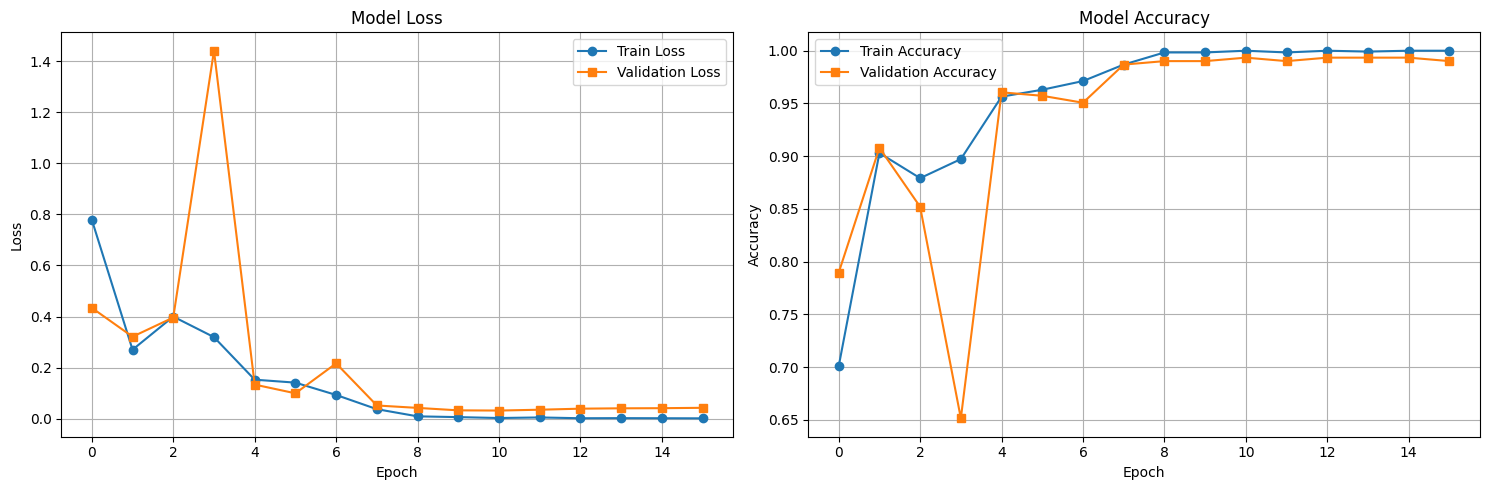

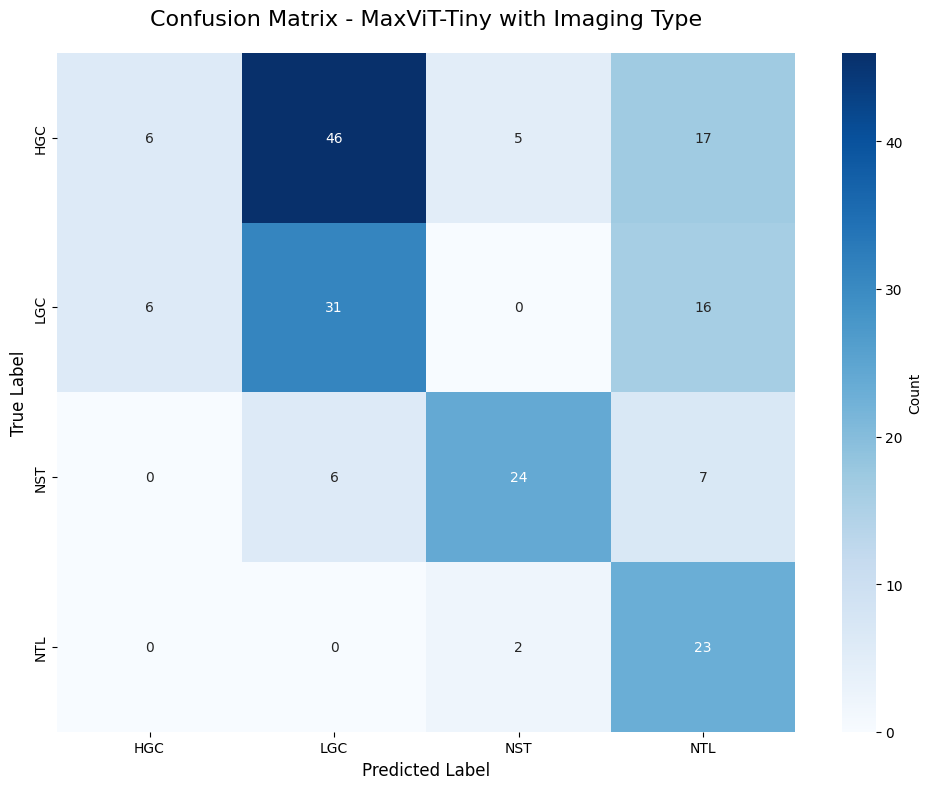

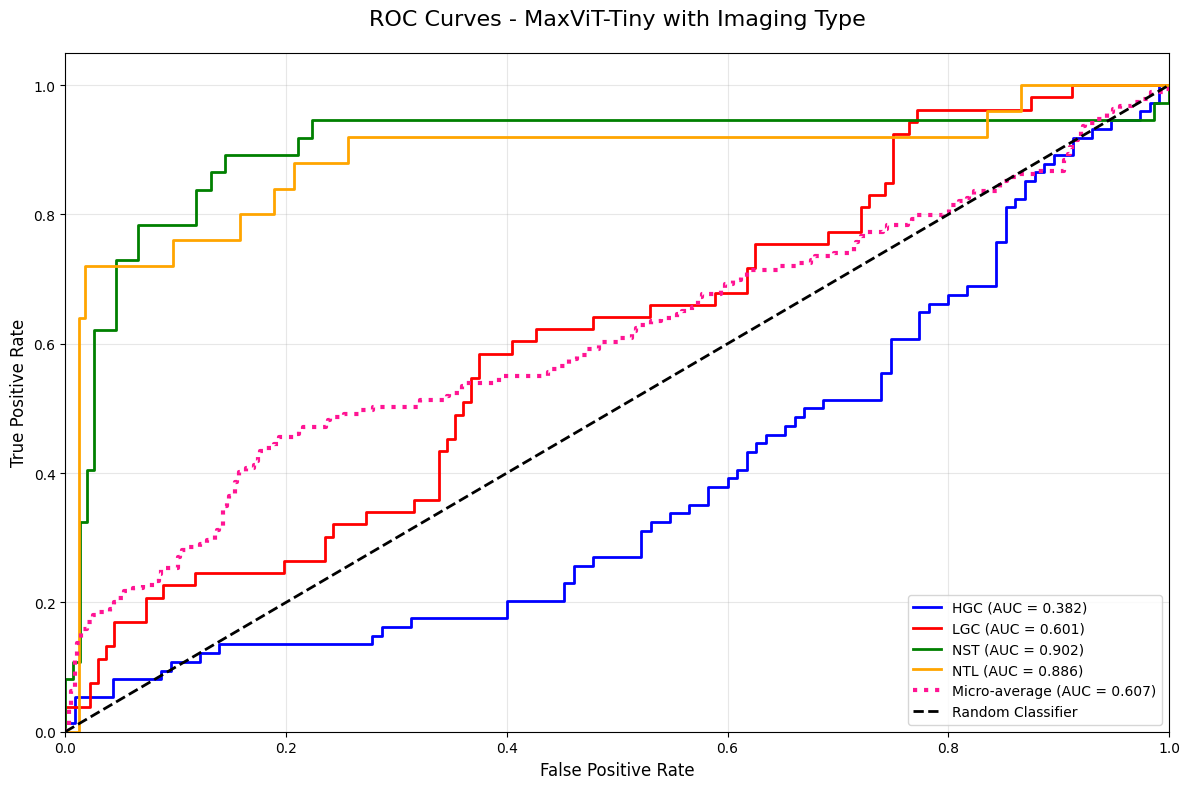


MaxViT-Tiny with Imaging Type training and evaluation complete!


In [16]:
print("=" * 80)
print("Training MaxViT-Tiny with Imaging Type")
print("=" * 80)

# Create model
maxvit_tiny = create_maxvit_model(model_type='tiny', num_classes=4, pretrained=True, 
                                  num_imaging_types=len(imaging_type_encoder.classes_), 
                                  embedding_dim=16)

# Create trainer
trainer_maxvit_tiny = ModelTrainer(maxvit_tiny, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_maxvit_tiny = trainer_maxvit_tiny.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MaxViT-Tiny_with_ImagingType")

# Plot training history
trainer_maxvit_tiny.plot_training_history(save_path='maxvit_tiny_with_imaging_type_training_history.png')

# Evaluate model
results_maxvit_tiny = trainer_maxvit_tiny.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_maxvit_tiny['confusion_matrix'], class_names, 'MaxViT-Tiny with Imaging Type',
                      save_path='maxvit_tiny_with_imaging_type_confusion_matrix.png')

# Plot ROC curves
roc_auc_maxvit_tiny = plot_roc_curves(results_maxvit_tiny['labels'], results_maxvit_tiny['probabilities'], class_names, 'MaxViT-Tiny with Imaging Type',
                                       save_path='maxvit_tiny_with_imaging_type_roc_curves.png')

# Store results
results_maxvit_tiny['model_name'] = 'MaxViT-Tiny'
results_maxvit_tiny['roc_auc'] = roc_auc_maxvit_tiny
all_results.append(results_maxvit_tiny)

print("\nMaxViT-Tiny with Imaging Type training and evaluation complete!")

## Train MaxViT-Small with Imaging Type

Training MaxViT-Small with Imaging Type


model.safetensors:   0%|          | 0.00/276M [00:00<?, ?B/s]

Starting training for 25 epochs...
------------------------------------------------------------
Epoch 1/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.34it/s, Loss=0.7790, Acc=0.7253]


Train Loss: 0.7790 Acc: 0.7253 Macro-F1: 0.6712


Val : 100%|██████████| 10/10 [00:02<00:00,  3.92it/s, Loss=0.6607, Acc=0.7862]


Val Loss: 0.6607 Acc: 0.7862 Macro-F1: 0.7420
✓ New best model saved with validation macro-F1: 0.7420

Epoch 2/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.4571, Acc=0.8520]


Train Loss: 0.4571 Acc: 0.8520 Macro-F1: 0.8125


Val : 100%|██████████| 10/10 [00:02<00:00,  3.91it/s, Loss=0.6570, Acc=0.7664]


Val Loss: 0.6570 Acc: 0.7664 Macro-F1: 0.7277

Epoch 3/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.2378, Acc=0.9317]


Train Loss: 0.2378 Acc: 0.9317 Macro-F1: 0.9081


Val : 100%|██████████| 10/10 [00:02<00:00,  3.86it/s, Loss=0.4157, Acc=0.8816]


Val Loss: 0.4157 Acc: 0.8816 Macro-F1: 0.8603
✓ New best model saved with validation macro-F1: 0.8603

Epoch 4/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.1624, Acc=0.9482]


Train Loss: 0.1624 Acc: 0.9482 Macro-F1: 0.9283


Val : 100%|██████████| 10/10 [00:02<00:00,  3.95it/s, Loss=0.6761, Acc=0.8322]


Val Loss: 0.6761 Acc: 0.8322 Macro-F1: 0.8315

Epoch 5/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.2102, Acc=0.9285]


Train Loss: 0.2102 Acc: 0.9285 Macro-F1: 0.9142


Val : 100%|██████████| 10/10 [00:02<00:00,  3.84it/s, Loss=0.1205, Acc=0.9671]


Val Loss: 0.1205 Acc: 0.9671 Macro-F1: 0.9574
✓ New best model saved with validation macro-F1: 0.9574

Epoch 6/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0617, Acc=0.9794]


Train Loss: 0.0617 Acc: 0.9794 Macro-F1: 0.9797


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.1384, Acc=0.9572]


Val Loss: 0.1384 Acc: 0.9572 Macro-F1: 0.9456

Epoch 7/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.1329, Acc=0.9597]


Train Loss: 0.1329 Acc: 0.9597 Macro-F1: 0.9501


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.1030, Acc=0.9704]


Val Loss: 0.1030 Acc: 0.9704 Macro-F1: 0.9606
✓ New best model saved with validation macro-F1: 0.9606

Epoch 8/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0544, Acc=0.9868]


Train Loss: 0.0544 Acc: 0.9868 Macro-F1: 0.9810


Val : 100%|██████████| 10/10 [00:02<00:00,  3.88it/s, Loss=0.0363, Acc=0.9836]


Val Loss: 0.0363 Acc: 0.9836 Macro-F1: 0.9830
✓ New best model saved with validation macro-F1: 0.9830

Epoch 9/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0142, Acc=0.9975]


Train Loss: 0.0142 Acc: 0.9975 Macro-F1: 0.9970


Val : 100%|██████████| 10/10 [00:02<00:00,  3.85it/s, Loss=0.0213, Acc=0.9901]


Val Loss: 0.0213 Acc: 0.9901 Macro-F1: 0.9834
✓ New best model saved with validation macro-F1: 0.9834

Epoch 10/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0115, Acc=0.9967]


Train Loss: 0.0115 Acc: 0.9967 Macro-F1: 0.9974


Val : 100%|██████████| 10/10 [00:02<00:00,  3.80it/s, Loss=0.0202, Acc=0.9901]


Val Loss: 0.0202 Acc: 0.9901 Macro-F1: 0.9834
✓ New best model saved with validation macro-F1: 0.9834

Epoch 11/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0058, Acc=0.9992]


Train Loss: 0.0058 Acc: 0.9992 Macro-F1: 0.9982


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.0227, Acc=0.9901]


Val Loss: 0.0227 Acc: 0.9901 Macro-F1: 0.9834

Epoch 12/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0035, Acc=1.0000]


Train Loss: 0.0035 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:02<00:00,  3.93it/s, Loss=0.0218, Acc=0.9901]


Val Loss: 0.0218 Acc: 0.9901 Macro-F1: 0.9834

Epoch 13/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.34it/s, Loss=0.0038, Acc=0.9992]


Train Loss: 0.0038 Acc: 0.9992 Macro-F1: 0.9993


Val : 100%|██████████| 10/10 [00:02<00:00,  3.90it/s, Loss=0.0222, Acc=0.9901]


Val Loss: 0.0222 Acc: 0.9901 Macro-F1: 0.9834

Epoch 14/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0026, Acc=0.9992]


Train Loss: 0.0026 Acc: 0.9992 Macro-F1: 0.9994


Val : 100%|██████████| 10/10 [00:02<00:00,  3.89it/s, Loss=0.0235, Acc=0.9901]


Val Loss: 0.0235 Acc: 0.9901 Macro-F1: 0.9834

Epoch 15/25
----------


Train : 100%|██████████| 38/38 [00:28<00:00,  1.35it/s, Loss=0.0023, Acc=1.0000]


Train Loss: 0.0023 Acc: 1.0000 Macro-F1: 1.0000


Val : 100%|██████████| 10/10 [00:02<00:00,  3.87it/s, Loss=0.0224, Acc=0.9901]


Val Loss: 0.0224 Acc: 0.9901 Macro-F1: 0.9834
Early stopping triggered after 15 epochs
Training complete in 7m 46s
Best validation macro-F1: 0.9834
Evaluating on test set...


100%|██████████| 6/6 [00:01<00:00,  3.41it/s]


Test Accuracy: 45.50%
Test Loss: 1.7711

Classification Report:
              precision    recall  f1-score   support

         HGC       0.55      0.41      0.47        74
         LGC       0.39      0.38      0.38        53
         NST       0.61      0.84      0.70        37
         NTL       0.16      0.20      0.18        25

    accuracy                           0.46       189
   macro avg       0.43      0.46      0.43       189
weighted avg       0.46      0.46      0.45       189


Confusion Matrix:
[[30 25  5 14]
 [21 20  3  9]
 [ 2  0 31  4]
 [ 2  6 12  5]]

ROC-AUC Scores:
Macro-average AUC: 0.7348
Micro-average AUC: 0.7408
HGC AUC: 0.7009
LGC AUC: 0.6462
NST AUC: 0.9056
NTL AUC: 0.6863


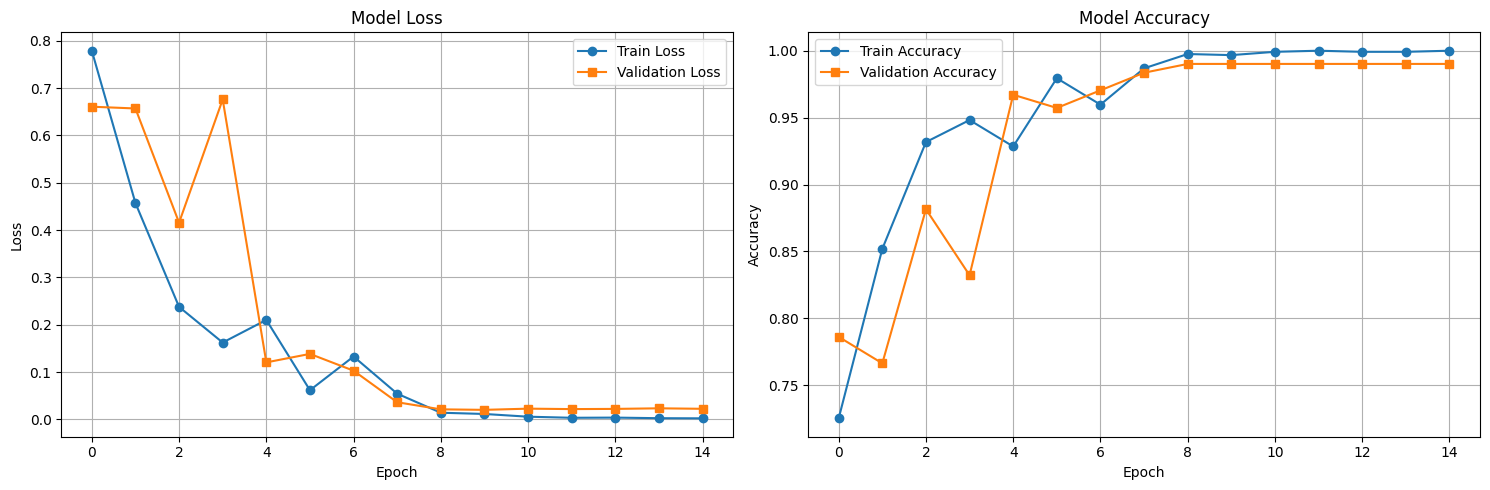

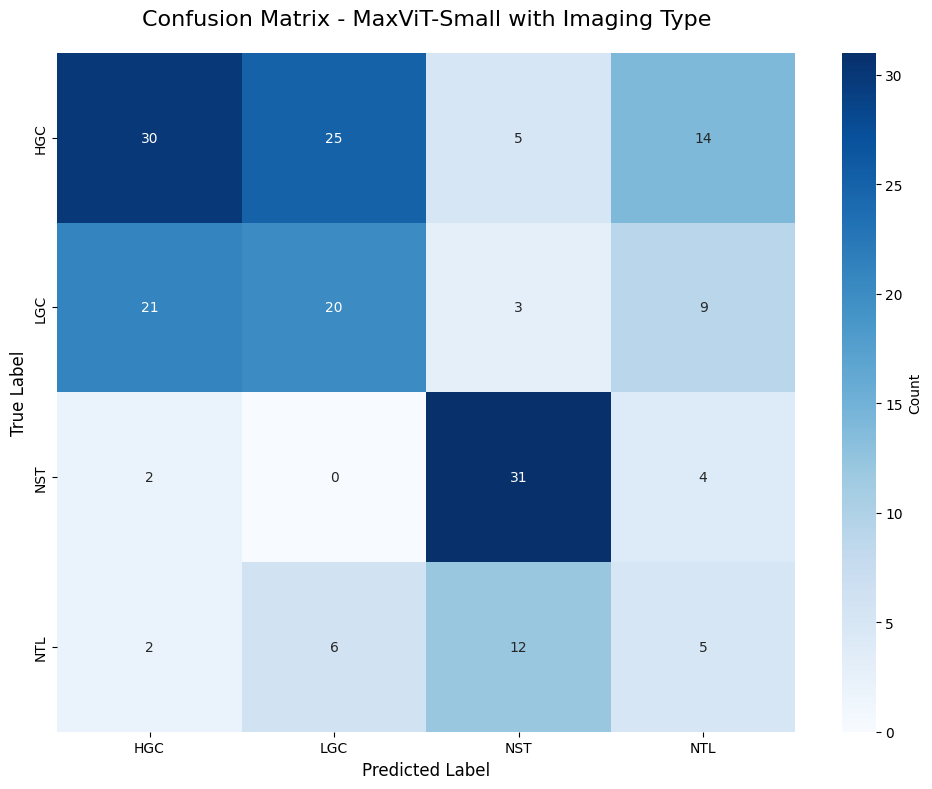

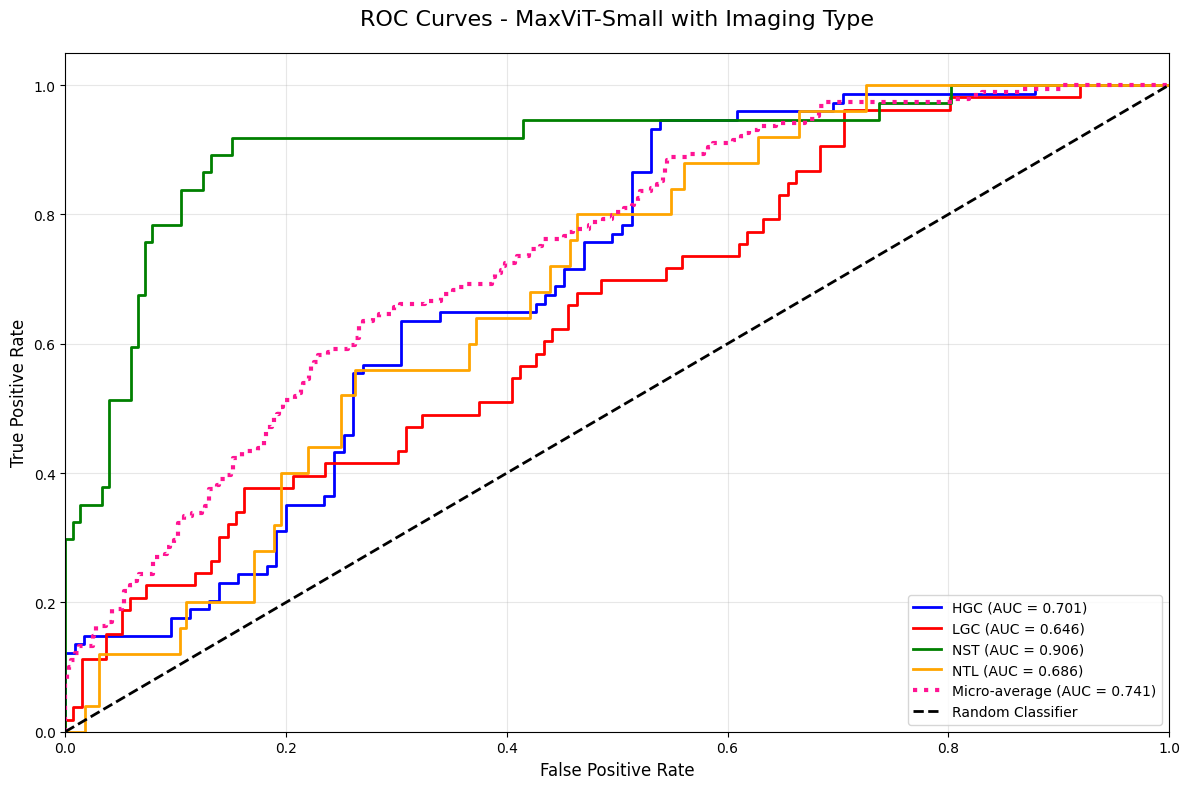


MaxViT-Small with Imaging Type training and evaluation complete!


In [17]:
print("=" * 80)
print("Training MaxViT-Small with Imaging Type")
print("=" * 80)

# Create model
maxvit_small = create_maxvit_model(model_type='small', num_classes=4, pretrained=True, 
                                   num_imaging_types=len(imaging_type_encoder.classes_), 
                                   embedding_dim=16)

# Create trainer
trainer_maxvit_small = ModelTrainer(maxvit_small, train_loader, val_loader, test_loader, device=device)

# Train model
trained_model_maxvit_small = trainer_maxvit_small.train_model(num_epochs=25, lr=0.001, save_best=True, model_name="MaxViT-Small_with_ImagingType")

# Plot training history
trainer_maxvit_small.plot_training_history(save_path='maxvit_small_with_imaging_type_training_history.png')

# Evaluate model
results_maxvit_small = trainer_maxvit_small.evaluate_model(class_names=class_names)

# Plot confusion matrix
plot_confusion_matrix(results_maxvit_small['confusion_matrix'], class_names, 'MaxViT-Small with Imaging Type',
                      save_path='maxvit_small_with_imaging_type_confusion_matrix.png')

# Plot ROC curves
roc_auc_maxvit_small = plot_roc_curves(results_maxvit_small['labels'], results_maxvit_small['probabilities'], class_names, 'MaxViT-Small with Imaging Type',
                                        save_path='maxvit_small_with_imaging_type_roc_curves.png')

# Store results
results_maxvit_small['model_name'] = 'MaxViT-Small'
results_maxvit_small['roc_auc'] = roc_auc_maxvit_small
all_results.append(results_maxvit_small)

print("\nMaxViT-Small with Imaging Type training and evaluation complete!")

# Save All Metrics to CSV

In [18]:
# Prepare data for CSV
metrics_data = []

for result in all_results:
    model_name = result['model_name']
    report = result['classification_report']
    
    # Overall metrics
    row = {
        'Model': model_name,
        'Overall_Accuracy': result['accuracy'],
        'Overall_Loss': result['loss'],
        'Macro_Avg_Precision': report['macro avg']['precision'],
        'Macro_Avg_Recall': report['macro avg']['recall'],
        'Macro_Avg_F1': report['macro avg']['f1-score'],
        'Weighted_Avg_Precision': report['weighted avg']['precision'],
        'Weighted_Avg_Recall': report['weighted avg']['recall'],
        'Weighted_Avg_F1': report['weighted avg']['f1-score'],
    }
    
    # Per-class metrics
    for class_name in class_names:
        row[f'{class_name}_Precision'] = report[class_name]['precision']
        row[f'{class_name}_Recall'] = report[class_name]['recall']
        row[f'{class_name}_F1'] = report[class_name]['f1-score']
        row[f'{class_name}_Support'] = report[class_name]['support']
    
    # ROC-AUC scores
    row['Macro_AUC'] = result['macro_auc']
    row['Micro_AUC'] = result['micro_auc']
    for class_name in class_names:
        row[f'{class_name}_AUC'] = result['per_class_auc'][class_name]
    
    # Also store ROC-AUC from plot_roc_curves if available
    if 'roc_auc' in result:
        for i, class_name in enumerate(class_names):
            row[f'{class_name}_Plot_AUC'] = result['roc_auc'][i]
        row['Micro_Avg_Plot_AUC'] = result['roc_auc']['micro']
    
    metrics_data.append(row)

# Create DataFrame
metrics_df = pd.DataFrame(metrics_data)

# Save to CSV
csv_path = 'MaxViT_with_ImagingType_metrics.csv'
metrics_df.to_csv(csv_path, index=False)

print(f"\nMetrics saved to: {csv_path}")
print("\nMetrics Summary:")
print(metrics_df.to_string())


Metrics saved to: MaxViT_with_ImagingType_metrics.csv

Metrics Summary:
          Model  Overall_Accuracy  Overall_Loss  Macro_Avg_Precision  Macro_Avg_Recall  Macro_Avg_F1  Weighted_Avg_Precision  Weighted_Avg_Recall  Weighted_Avg_F1  HGC_Precision  HGC_Recall    HGC_F1  HGC_Support  LGC_Precision  LGC_Recall    LGC_F1  LGC_Support  NST_Precision  NST_Recall    NST_F1  NST_Support  NTL_Precision  NTL_Recall    NTL_F1  NTL_Support  Macro_AUC  Micro_AUC   HGC_AUC   LGC_AUC   NST_AUC   NTL_AUC  HGC_Plot_AUC  LGC_Plot_AUC  NST_Plot_AUC  NTL_Plot_AUC  Micro_Avg_Plot_AUC
0   MaxViT-Tiny         44.444444       3.30508             0.503192          0.558659      0.456007                0.500356             0.444444         0.389805       0.500000    0.081081  0.139535         74.0       0.373494    0.584906  0.455882         53.0       0.774194    0.648649  0.705882         37.0       0.365079        0.92  0.522727         25.0   0.692640   0.606935  0.381786  0.600583  0.901849  0.886341  